In [1]:
import tensorflow as tf
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt

import err_checks
import tensorflow_benchmarking

In [2]:
%matplotlib inline

# Distribution Plots

In [3]:
def generate_coherent_states(N, alpha):
    displs = tf.cast(tf.linspace(tf.constant(0, dtype=tf.float32), np.pi, 100), dtype=tf.complex64)
    displs = tf.map_fn(lambda theta: np.abs(alpha) * tf.math.exp(1j * theta), displs)
    analytic = err_checks.coherent_analytic(N, displs)

    vac = tf.cast(tf.one_hot(0, N), dtype=tf.complex64)
        
    _, bch_op = tensorflow_benchmarking.eager_benchmark_BCH(N, displs, '/device:CPU:0', rep=1)
    numeric_bch = tf.linalg.matvec(bch_op, vac)
    
    _, op = tensorflow_benchmarking.eager_benchmark(N, displs, '/device:CPU:0', rep=1)
    numeric = tf.linalg.matvec(op, vac)
    
    return analytic, numeric_bch, numeric

In [4]:
def log_abs_err(test, ref):
    abs_err = tf.math.abs(test - ref)
    log_abs_err = tf.clip_by_value(tf.math.log(abs_err) / tf.math.log(10.), -38, 0)
    return abs_err, log_abs_err

In [5]:
def log_rel_err(test, ref):
    rel_err = tf.clip_by_value(tf.math.divide_no_nan(tf.math.abs(test - ref), tf.math.abs(ref)), 1e-8, 10)
    log_rel_err = tf.math.log(rel_err) / tf.math.log(10.)
    return rel_err, log_rel_err

In [6]:
def plot_abs_err(N, alpha):
    analytic, numeric_bch, numeric = generate_coherent_states(N, alpha)

    _, n_err = log_abs_err(numeric, analytic)
    _, nbch_err = log_abs_err(numeric_bch, analytic)
    
    _, n_err_r = log_rel_err(numeric, analytic)
    _, nbch_err_r = log_rel_err(numeric_bch, analytic)

    comb = tf.concat([n_err, nbch_err], axis=0)
    vmax = tf.reduce_max(tf.boolean_mask(comb, tf.math.is_finite(comb)))
    vmin = tf.reduce_min(tf.boolean_mask(comb, tf.math.is_finite(comb)))
    
    comb_r = tf.concat([n_err_r, nbch_err_r], axis=0)
    vmax_r = tf.reduce_max(tf.boolean_mask(comb_r, tf.math.is_finite(comb_r)))
    vmin_r = tf.reduce_min(tf.boolean_mask(comb_r, tf.math.is_finite(comb_r)))
    
    fig = plt.figure(figsize=(15, 12))
    ax0 = fig.add_subplot(311)
    ax1 = fig.add_subplot(323)
    ax2 = fig.add_subplot(324)
    ax3 = fig.add_subplot(325)
    ax4 = fig.add_subplot(326)

    im1 = ax1.imshow(n_err, interpolation='nearest', aspect=0.5 * N / 100, vmin=vmin, vmax=vmax)
    im2 = ax2.imshow(nbch_err, interpolation='nearest', aspect=0.5 * N / 100, vmin=vmin, vmax=vmax)
    cb1 = fig.colorbar(im1, ax=[ax1, ax2])
    cb1.set_label('Log Absolute Error')
    ax1.set_title('Expm')
    ax2.set_title('BCH')
    
    im3 = ax3.imshow(n_err_r, interpolation='nearest', aspect=0.5 * N / 100, vmin=vmin_r, vmax=vmax_r,)
    im4 = ax4.imshow(nbch_err_r, interpolation='nearest', aspect=0.5 * N / 100, vmin=vmin_r, vmax=vmax_r)
    cb2 = fig.colorbar(im3, ax=[ax3, ax4])
    cb2.set_label('Log Relative Error')
    ax3.set_title('Expm (Relative)')
    ax4.set_title('BCH (Relative)')

    proba = tf.reduce_mean(tf.cast(tf.math.conj(analytic) * analytic, dtype=tf.float32), axis=0)
    probn = tf.reduce_mean(tf.cast(tf.math.conj(numeric) * numeric, dtype=tf.float32), axis=0)
    probbch = tf.reduce_mean(tf.cast(tf.math.conj(numeric_bch) * numeric_bch, dtype=tf.float32), axis=0)
    ax0.plot(proba, label='Analytic')
    ax0.plot(probn, label='Expm')
    ax0.plot(probbch, label='BCH')
    ax0.set_yscale("log")
    ax0.set_ylabel('Log Prob')
    ax0.legend()
    fig.suptitle('N = %i, α = %i' % (N, alpha), y=0.92, fontsize=16)

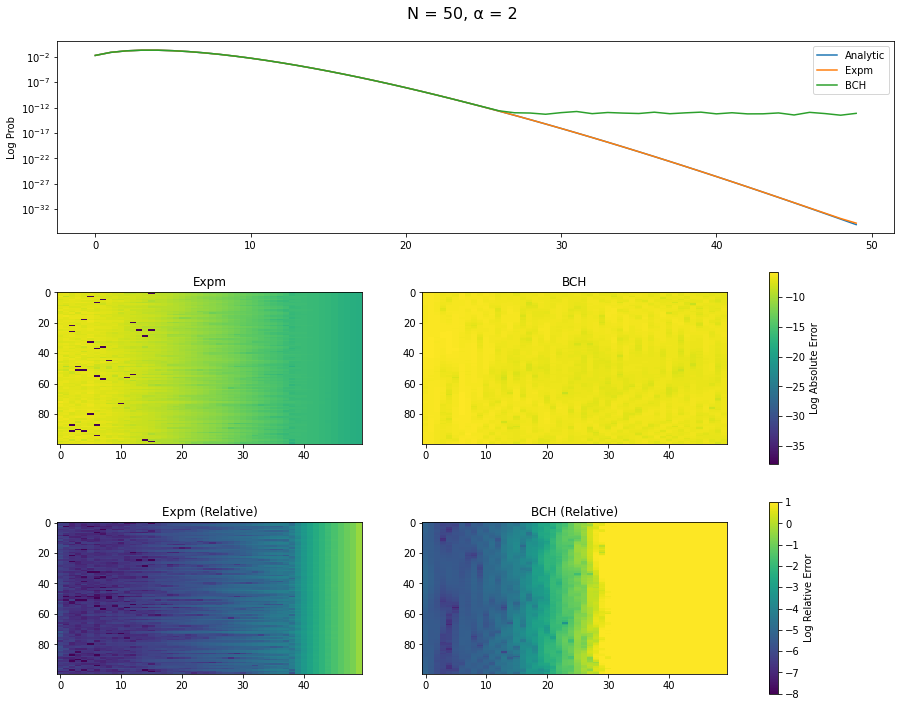

In [7]:
plot_abs_err(50, 2)

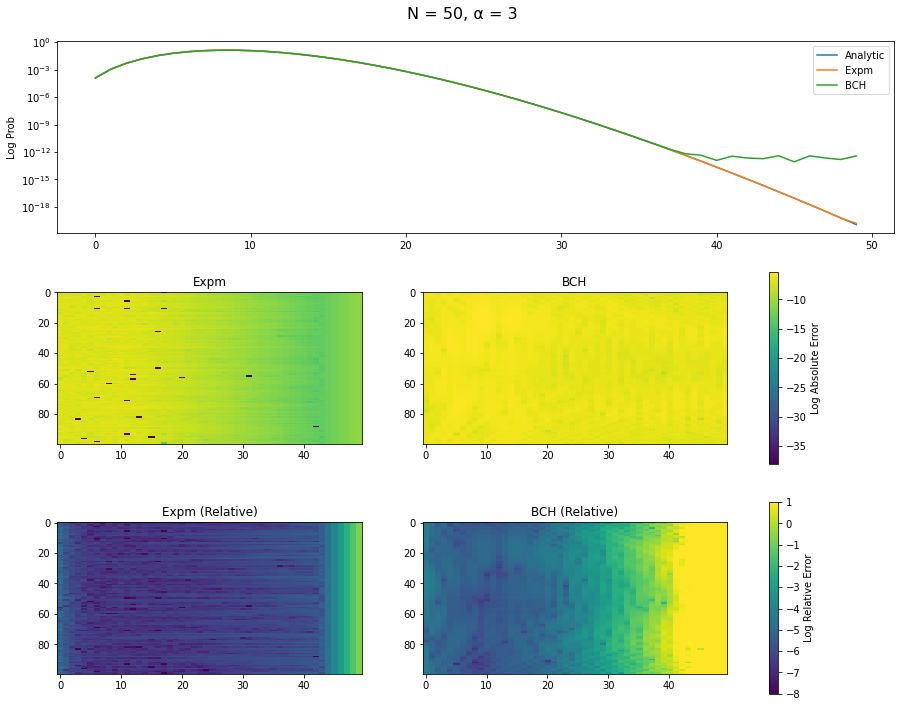

In [8]:
plot_abs_err(50, 3)

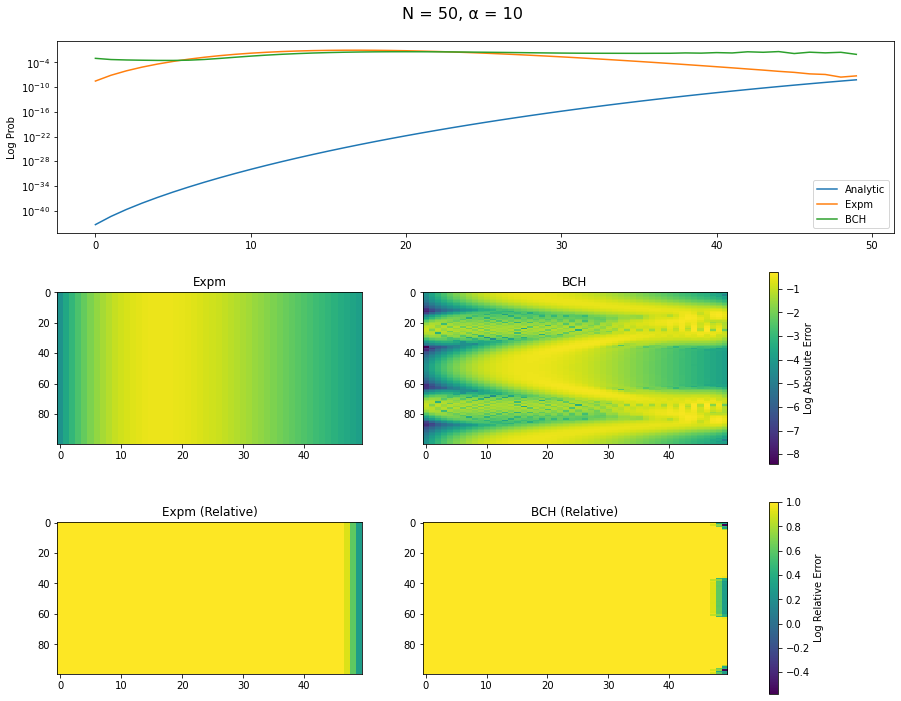

In [9]:
plot_abs_err(50, 10)

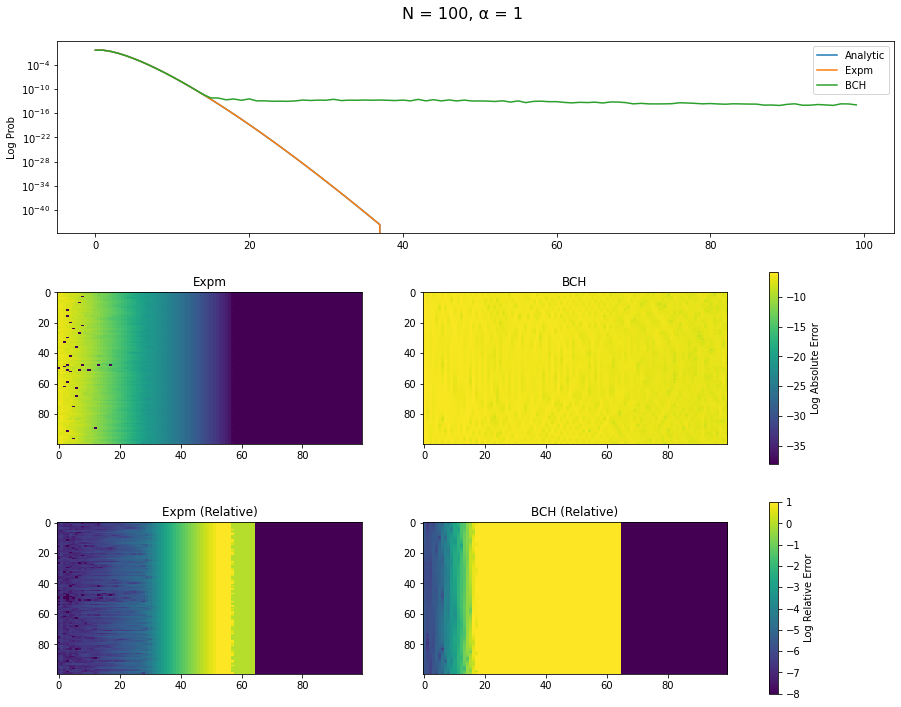

In [10]:
plot_abs_err(100, 1)

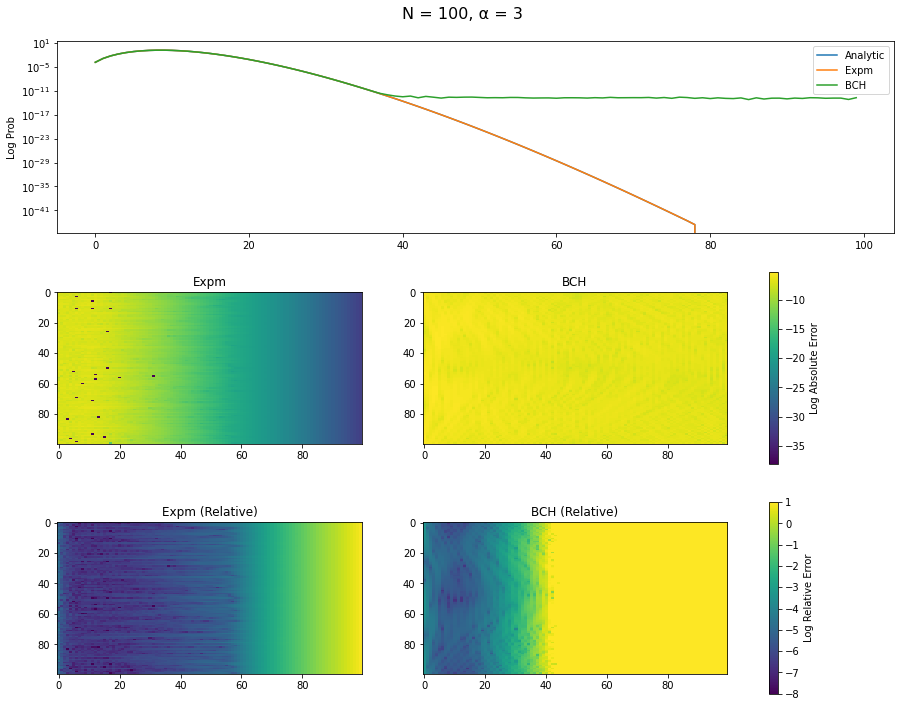

In [11]:
plot_abs_err(100, 3)

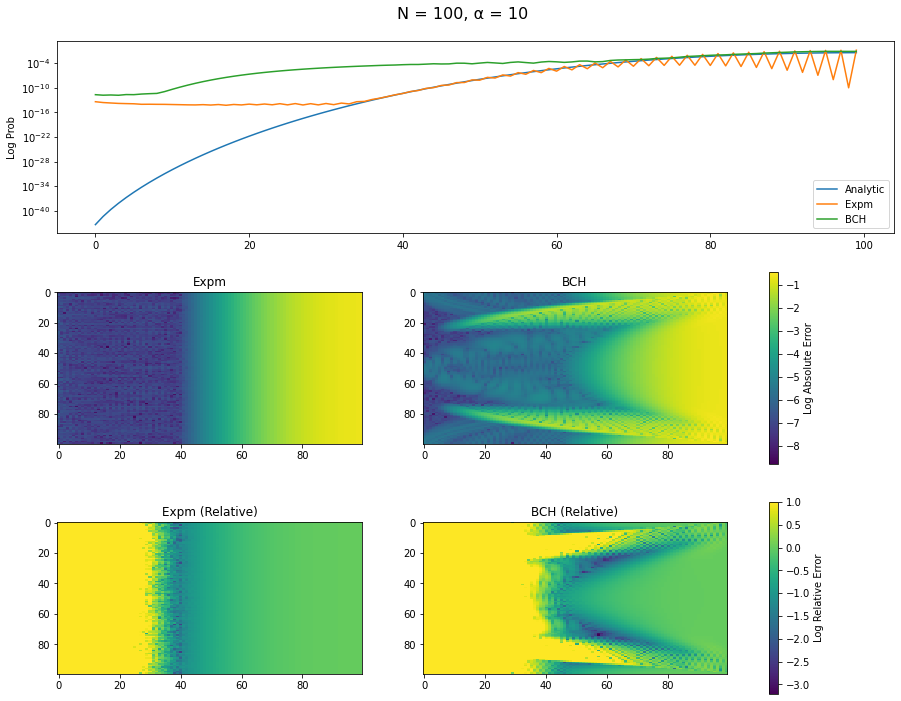

In [12]:
plot_abs_err(100, 10)

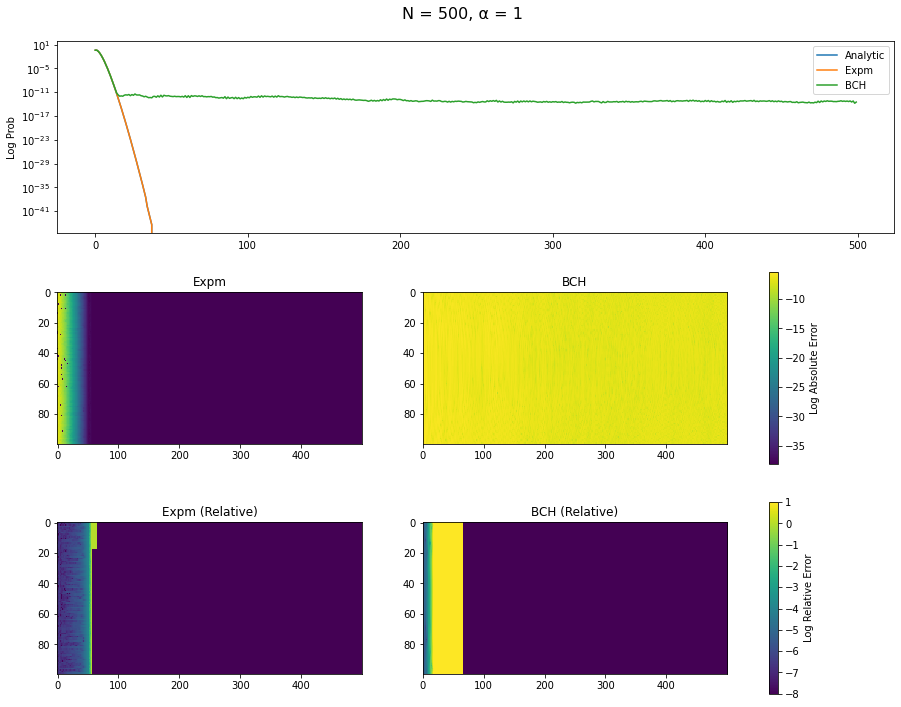

In [13]:
plot_abs_err(500, 1)

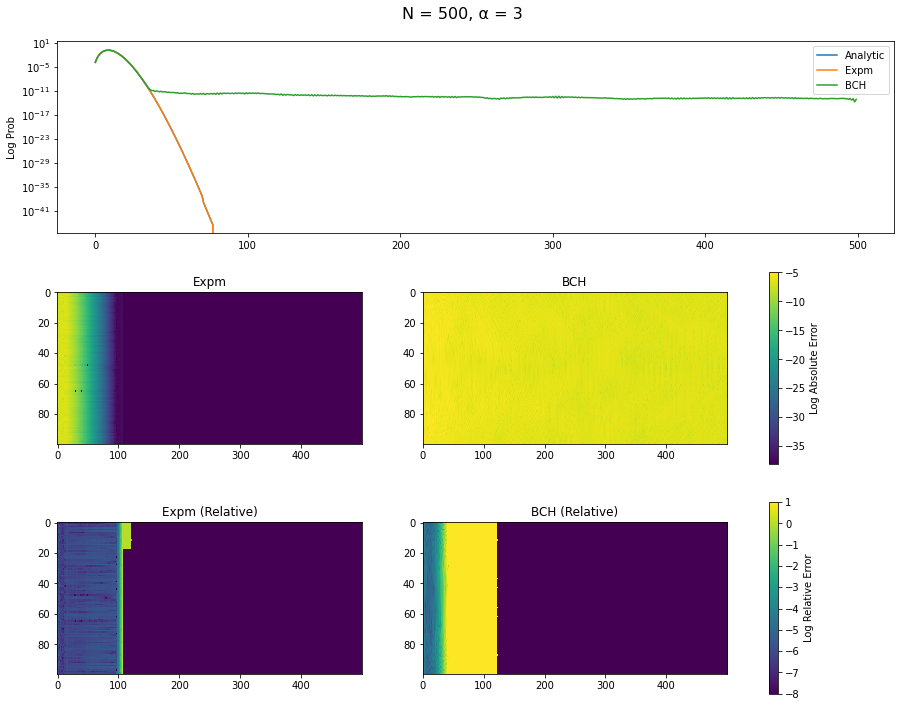

In [14]:
plot_abs_err(500, 3)

In [ ]:
plot_abs_err(500, 10)